In [ ]:
import os
import gensim
from gensim.models import Phrases
import gensim.corpora as corpora
from pprint import pprint
import numpy as np

In [ ]:
!pip install pymorphy2
import pymorphy2
morph = pymorphy2.MorphAnalyzer()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 55 kB 4.0 MB/s 
     |████████████████████████████████| 8.2 MB 24.2 MB/s 
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13723 sha256=6e7605aecc89f88b5f8a35b3d5d417cc046b179e695adf903284dc486aeaa881
  Stored in directory: /root/.cache/pip/wheels/56/ea/58/ead137b087d9e326852a851351d1debf4ada529b6ac0ec4e8c
Successfully built docopt


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
path = '/content/drive/MyDrive/LingCorp/LingCorp'

Mounted at /content/drive


In [ ]:
with open('/content/drive/MyDrive/LingCorp/swl_optimum.txt', 'r', encoding='utf-8') as swl_file:
    swl = swl_file.readlines()

swl = [w.strip() for w in swl]
names = {}
files = os.listdir(path)
docs = []
id2doc = {}

for i, file in enumerate(files):
    with open(path + '/' + file, 'r', encoding='utf-8') as text_file:
        text = text_file.read().split()
        text = [word for word in text if not word in swl]
        text = [word for word in text if word.isalpha() and len(word) > 2]
        docs.append(text)
        file_id = file.split("_")[0]
        id2doc[i] = file_id

In [ ]:
docs_lemmatized = []
for i in range(0, len(docs)):
  text_lemmatized = []
  for word in docs[i]:
    word = morph.parse(word)[0].normal_form
    text_lemmatized.append(word)
  docs_lemmatized.append(text_lemmatized)

In [ ]:
docs_lemmatized

In [ ]:
files = os.listdir(path)
bigram = Phrases(docs_lemmatized, min_count=4)
bigram_mod = gensim.models.phrases.Phraser(bigram)
docs_lemmatized_phraser = [bigram_mod[doc] for doc in docs_lemmatized]
id2word = corpora.Dictionary(docs_lemmatized_phraser)
id2word.filter_extremes(no_below=3, no_above=0.9)
corpus = [id2word.doc2bow(text) for text in docs_lemmatized_phraser]

In [ ]:
docs_lemmatized_phraser[-3]

In [ ]:
from gensim.models import CoherenceModel

def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=5):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                                id2word=id2word,
                                                num_topics=num_topics,
                                                passes = 10,
                                                iterations=100,
                                                eval_every = 1
                                                )
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [ ]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [ ]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=docs_lemmatized_phraser, start=5, limit=30, step=5)

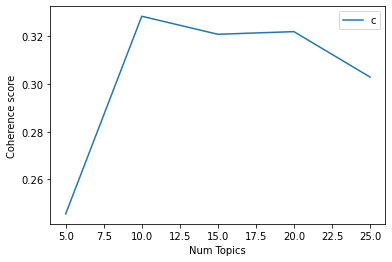

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
limit=30; start=5; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [ ]:
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 5  has Coherence Value of 0.2455
Num Topics = 10  has Coherence Value of 0.3285
Num Topics = 15  has Coherence Value of 0.3209
Num Topics = 20  has Coherence Value of 0.322
Num Topics = 25  has Coherence Value of 0.3029


In [ ]:
optimal_model = model_list[4]
model_topics = optimal_model.print_topics(-1, 20)
pprint(model_topics)

In [ ]:
import re
topics = {}
for i in range (0, len(model_topics)):
  words = re.findall(r'[а-яёА-ЯЁ]+', model_topics[i][1])
  topics[i]= words

# Подбор меток из векторной модели

In [ ]:
import gensim
from gensim.models.word2vec import Word2Vec 
from gensim.models import KeyedVectors 

In [ ]:
!unzip '/content/drive/MyDrive/LingCorp/220.zip' -d 'ruwikiruscorpora_cbow_300'

Archive:  /content/drive/MyDrive/LingCorp/220.zip
  inflating: ruwikiruscorpora_cbow_300/meta.json  
  inflating: ruwikiruscorpora_cbow_300/model.bin  
  inflating: ruwikiruscorpora_cbow_300/model.txt  
  inflating: ruwikiruscorpora_cbow_300/README  


In [ ]:
model = gensim.models.KeyedVectors.load_word2vec_format('ruwikiruscorpora_cbow_300/model.bin', binary=True) 

In [ ]:
pos = {'ADJF': 'ADJ', 'INFN': 'VERB'}
vector_dic = {}
for num, words in enumerate(topics):
  word_vectors = []
  for word in topics[num]:
    POS = morph.parse(word)[0].tag.POS
    if pos.get(POS):
      POS = pos.get(POS)
    word = word + '_' + POS
    try: 
      word_vectors.append(model.wv[word])
    except KeyError:
      pass 
  vector_dic[num] = word_vectors

<ipython-input-37-51a6e2976454>:11: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  word_vectors.append(model.wv[word])


In [ ]:
mean_vector = []
for i in range(len(vector_dic)):
  meanvec = np.mean(vector_dic[i], 0)
  mean_vector.append(meanvec)

In [ ]:
similar_words = {}
labels = {}
labels_tmp = []
for i, vectors in enumerate(mean_vector):
  similar_words[i] = model.similar_by_vector(vector = vectors, topn = 3)
  labels_tmp = []
  for j in range (len(similar_words[i])):
    labels_tmp.append((similar_words[i][j][0]).split("_")[0])
  labels[i] = labels_tmp

In [ ]:
for key, value in topics.items():
  print(f'TOPIC: {" ".join(topics[key])} \nLABELS: {" ".join(labels[key])}\n')

TOPIC: слово который текст смысл два это быть китайский свой такой первый этот другой сам язык один система железный диалект мера 
LABELS: слово смысл понятие

TOPIC: слово язык ударение это такой этот один значение разный являться признак понятие который единица связать другой быть следовать основание граница 
LABELS: понятие например смысл

TOPIC: язык который быть первый другой грамматический семиотический понятие особый несколько иметься основа знак распространить слово дравидийский конструкция наука характерный называть 
LABELS: понятие например иной

TOPIC: система языковой идея связанный развивать соссюра организовать выделить язык лингвистика речь обозначать предмет конкретный школа процесс лингвистический традиция поздний два 
LABELS: понятие языковой семантика

TOPIC: один который термин семиотический понятие слово весь текст лексический значение определённый знак единство считаться школа разный работа другой грамматический отдельный 
LABELS: понятие иной термин

TOPIC: англи

# WordNet:

In [ ]:
!pip install ruwordnet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for ruwordnet: filename=ruwordnet-0.0.5-py3-none-any.whl size=12645 sha256=f061efc1dd03f7430888cc4ba720f017f49e9998e805343237fcec4866160963
  Stored in directory: /root/.cache/pip/wheels/1a/8f/87/368fccb66c06c5ce100b0985a7d0727fc1f2b97d24b6474c69
Successfully built ruwordnet


In [ ]:
from ruwordnet import RuWordNet
wn = RuWordNet(filename_or_session='/content/drive/MyDrive/LingCorp/ruwordnet-2021.db')

In [ ]:
wndict = {}
for key, top in labels.items():
  hypers = []
  for word in top:
    hyper_temp = []
    for i in range(len(wn.get_senses(word))):
      try: 
        hyper = wn.get_senses(word)[i].synset.hypernyms
        for k in range(len(hyper)):
          word_tmp = str(hyper[k])
          title = re.findall('[А-ЯЁ ]+', word_tmp)
          hyper_temp.append(title[1].strip(' '))
      except IndexError:
        pass
    if hyper_temp != []:
      hypers.append(set(hyper_temp)) 
  wndict[key] = hypers  

In [ ]:
wndict

{0: [{'ЕДИНИЦА ЯЗЫКА', 'СУЖДЕНИЕ'},
  {'АБСТРАКТНАЯ СУЩНОСТЬ', 'СУТЬ'},
  {'МЕНТАЛЬНЫЙ ОБЪЕКТ'}],
 1: [{'МЕНТАЛЬНЫЙ ОБЪЕКТ'}, {'АБСТРАКТНАЯ СУЩНОСТЬ', 'СУТЬ'}],
 2: [{'МЕНТАЛЬНЫЙ ОБЪЕКТ'}],
 3: [{'МЕНТАЛЬНЫЙ ОБЪЕКТ'}, {'СИСТЕМА'}, {'ЛЕКСИКОЛОГИЯ', 'СМЫСЛ'}],
 4: [{'МЕНТАЛЬНЫЙ ОБЪЕКТ'}, {'СЛОВО ЯЗЫКА', 'СЛОВОСОЧЕТАНИЕ'}],
 5: [{'УЗНАТЬ', 'УЧИТЬСЯ'},
  {'ПРОФЕССОРСКО', 'УЧЕНОЕ ЗВАНИЕ'},
  {'ЛИНГВИСТИКА'}],
 6: [{'МЕНТАЛЬНЫЙ ОБЪЕКТ'},
  {'СЛОВО ЯЗЫКА', 'СЛОВОСОЧЕТАНИЕ'},
  {'СЛОВО ЯЗЫКА', 'СЛОВОСОЧЕТАНИЕ'}],
 7: [{'ПЕРЕДОВОЙ', 'СВОЙСТВО'}, {'ЕДИНИЦА ЯЗЫКА', 'СУЖДЕНИЕ'}],
 8: [{'МЯСНЫЕ СУБПРОДУКТЫ', 'ОРГАНЫ ЧУВСТВ', 'СИСТЕМА'},
  {'ЕДИНИЦА ЯЗЫКА', 'СУЖДЕНИЕ'}],
 9: [{'МЕНТАЛЬНЫЙ ОБЪЕКТ'}, {'СЛОВО ЯЗЫКА'}, {'СТРОЕНИЕ'}],
 10: [{'ЕДИНИЦА ЯЗЫКА', 'СУЖДЕНИЕ'},
  {'МЯСНЫЕ СУБПРОДУКТЫ', 'ОРГАНЫ ЧУВСТВ', 'СИСТЕМА'},
  {'ЗАПИСЬ'}],
 11: [{'ЕДИНИЦА ЯЗЫКА', 'СУЖДЕНИЕ'},
  {'АБСТРАКТНАЯ СУЩНОСТЬ', 'СУТЬ'},
  {'МЕНТАЛЬНЫЙ ОБЪЕКТ'}],
 12: [{'АСПЕКТ', 'МНЕНИЕ', 'МЫСЛИТЕЛЬНЫЙ ПРОЦЕСС'},
  {'МЕНТАЛЬНЫЙ ОБ

In [ ]:
wn_labels = {}
for key, values in wndict.items():
  common_list = []
  for i in range(len(wndict[key])):
    for j in range(len(wndict[key])):
      try:
        if wndict[key][i] !=  wndict[key][j]:
          common = wndict[key][i] & wndict[key][j]
          if common != set() and common not in common_list:
            common_list.append(common)
      except IndexError:
        pass
  wn_labels[key] = common_list[0:3]

In [ ]:
list_wn = {}
t = 0
for i in wn_labels.values():
  print_list = []
  for j in i:
    for k in j:
      print_list.append(k)
  list_wn[t] = list(set(print_list[0:3]))
  t += 1

In [ ]:
for key, value in list_wn.items():
  print(f'TOPIC: {" ".join(topics[key])}\nLABELS: {" | ".join(list_wn[key])}\n')

TOPIC: слово который текст смысл два это быть китайский свой такой первый этот другой сам язык один система железный диалект мера
LABELS: 

TOPIC: слово язык ударение это такой этот один значение разный являться признак понятие который единица связать другой быть следовать основание граница
LABELS: 

TOPIC: язык который быть первый другой грамматический семиотический понятие особый несколько иметься основа знак распространить слово дравидийский конструкция наука характерный называть
LABELS: 

TOPIC: система языковой идея связанный развивать соссюра организовать выделить язык лингвистика речь обозначать предмет конкретный школа процесс лингвистический традиция поздний два
LABELS: 

TOPIC: один который термин семиотический понятие слово весь текст лексический значение определённый знак единство считаться школа разный работа другой грамматический отдельный
LABELS: 

TOPIC: английский университет быть степень получить главный многий он международный профессор преподавать специалист родитьс